In [183]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [184]:
print(tf.__version__)

2.0.0


In [185]:
def data_processing(file_name, file_name_D):
    """
    Read the csv files and create game characterstic features and player statistic features
    """
    df = pd.read_csv(file_name)
    df_D = pd.read_csv(file_name_D)
    df.sort_values(by = ['Name', 'Unnamed: 2_level_0 G#']) # for rolling average
    # All box score player stats, except defensive statistics
    stats = ['Passing AY/A', 'Passing Cmp%',
            'Passing Int','Passing Y/A','Rushing Yds','FPoints']
    # Opponent Characteristics
    df, opp_features = get_opp_d(df, df_D)
    # Game Characteristic Indicators, e.g. home/away, opponent, team
#     df, game_features = get_game_char_indicators(df)
    # Player Statistic Features, e.g. Season, last 4 weeks, previous week
    df, player_features = get_player_averages(df, stats)
#     features = game_features + player_features
#     features = player_features
    df['home'] = (df['Unnamed: 6_level_0 Unnamed: 6_level_1'] == '0')*1
    features = player_features + opp_features + ['home']
    df = df.fillna(0)
    return df, features


def get_game_char_indicators(df):
    """
    Transform str cols into game categorical variables
    Returns transformed and columns
    """
    df['home'] = 1 * df['Unnamed: 6_level_0 Unnamed: 6_level_1'] == '0'
    oppts = pd.get_dummies(df['Unnamed: 7_level_0 Opp'], prefix='Oppt')
    teams = pd.DataFrame()
    team_list = pd.Series('ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET',\
                           'GB', 'HOU', 'IND', 'JAC', 'KC', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ',\
                           'OAK', 'PHI', 'PIT', 'SD', 'SEA', 'SF', 'STL', 'TB', 'TEN', 'WAS')
    for team in df['Unnamed: 5_level_0 Tm']:
        temp = (team_list == team)
        teams = teams.append(temp, ignore_index=True)
    teams.index = range(len(df['Unnamed: 5_level_0 Tm']))
    teams.columns = list(team_list)
    df = pd.concat([df, oppts, teams], axis=1)
    return df, ['home'] + list(oppts.columns) + list(team_list)

def get_opp_d(df, df_D):

    d_stats = ['Passing Cmp','Passing Att',
             'Passing Yds','Passing TD','Passing Int','Passing NY/A','Passing 1stD','Sc%','Unnamed: 26_level_0 TO%']
    df_D['Season']= df_D['Season'].astype(str)
#     for stat in df[d_stats + ['FPoints']]:
#         opp = abbrev_dict[df['Unnamed: 7_level_0 Opp']]
#         df['D_'+stat] = df_D.loc[df_D['Tm'] == opp][stat]
    for stat in d_stats:
#         print(stat)
        df[stat] = df.apply(lambda row: get_team_stat(row,stat,df_D), axis=1)
    return df, d_stats
def get_team_stat(row,stat,df_D):
    abbrev_dict = {'ARI':'Arizona Cardinals', 'ATL':'Atlanta Falcons', 'BAL':'Baltimore Ravens', 'BUF':'Buffalo Bills', 
                          'CAR':'Carolina Panthers', 'CHI':'Chicago Bears', 'CIN':'Cincinnati Bengals', 
                          'CLE':'Cleveland Browns', 'DAL':'Dallas Cowboys', 'DEN':'Denver Broncos', 'DET':'Detroit Lions', 
                          'GB':'Green Bay Packers','GNB':'Green Bay Packers', 'HOU': 'Houston Texans', 'IND':'Indianapolis Colts', 
                          'JAC':'Jacksonville Jaguars', 'JAX':'Jacksonville Jaguars','KAN':'Kansas City Chiefs','KC':'Kansas City Chiefs','LAC':'Los Angeles Chargers',
                          'LAR':'Los Angeles Rams', 'MIA':'Miami Dolphins', 'MIN':'Minnesota Vikings','NE':'New England Patriots','NWE':'New England Patriots',
                          'NO':'New Orleans Saints','NOR':'New Orleans Saints', 'NYG':'New York Giants', 'NYJ':'New York Jets','OAK':'Oakland Raiders', 
                          'PHI':'Philadelphia Eagles', 'PIT':'Pittsburgh Steelers', 'SD':'San Diego Chargers', 'SDG':'San Diego Chargers', 'SEA':'Seattle Seahawks', 
                          'SF':'San Francisco 49ers', 'SFO':'San Francisco 49ers','STL':'St. Louis Rams', 'TB':'Tampa Bay Buccaneers',
                           'TEN':'Tennessee Titans', 'TAM':'Tampa Bay Buccaneers',
                          'WAS':'Washington Redskins'}
#     print(row)
#     print(df_D['Season'])
    df_D.index=df_D['Tm']+df_D['Season']
#     print(df_D)
    opp = abbrev_dict[row['Unnamed: 7_level_0 Opp']]+str(row['Season'])
#     print(type(df_D.loc[df_D['Tm']==opp][stat]))
#     print(opp,stat)
    return df_D.at[opp,stat]

def rolling_average(df, window):
    return df.rolling(min_periods=1, window=window).mean().shift(1)

def get_player_averages(df, stats):
    """
    Estimate player averages for all stats and FanDuel point histories,
    for season-to-date, last 4 weeeks, and previous week
    """
    feature_names = []
    for stat in df[stats + ['FPoints']]:
        df['season_{}'.format(stat)] = df.groupby('Name')[stat].apply(lambda x: rolling_average(x, 16))
        df['recent_{}'.format(stat)] = df.groupby('Name')[stat].apply(lambda x: rolling_average(x, 4))
        df['prev_{}'.format(stat)] = df.groupby('Name')[stat].apply(lambda x: rolling_average(x, 1))
        feature_names = feature_names + [time + "_" + stat for time in ['season', 'recent', 'prev']]
#         feature_names = feature_names + [time + "_" + stat for time in ['recent', 'prev']]
    return df, feature_names


path = "data/"
train, features = data_processing(path + 'QB_all.csv', path + 'teams_all.csv')
# test, features2 = data_processing(path + 'gamelog_QB_2018.csv', path + 'teams_2018.csv')
# if (features != features2):
#     print("Debug error about feature inconsistency")
#     exit()

In [186]:
train

,Unnamed: 0,Def. Snaps Num,Def. Snaps Pct,FPoints,Fumbles FF,Fumbles FR,Fumbles Fmb,Fumbles TD,Fumbles Yds,Kick Returns Rt,...,season_Passing Y/A,recent_Passing Y/A,prev_Passing Y/A,season_Rushing Yds,recent_Rushing Yds,prev_Rushing Yds,season_FPoints,recent_FPoints,prev_FPoints,home
0,0,0.0,0,23.52,0.0,0.0,1.0,0.0,-17.0,0.0,...,0.000000,0.0000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.00,1
1,1,0.0,0,9.54,0.0,0.0,0.0,0.0,0.0,0.0,...,10.720000,10.7200,10.72,-2.000000,-2.000000,-2.0,23.520000,23.520000,23.52,0
2,2,0.0,0,20.84,0.0,0.0,1.0,0.0,0.0,0.0,...,8.635000,8.6350,6.55,3.500000,3.500000,9.0,16.530000,16.530000,9.54,0
3,3,0.0,0,24.42,0.0,0.0,0.0,0.0,0.0,0.0,...,8.680000,8.6800,8.77,2.333333,2.333333,0.0,17.966667,17.966667,20.84,1
4,4,0.0,0,11.80,0.0,0.0,3.0,0.0,-17.0,0.0,...,9.102500,9.1025,10.37,1.500000,1.500000,-1.0,19.580000,19.580000,24.42,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,5876,0.0,0%,0.00,0.0,0.0,0.0,0.0,0.0,2.0,...,4.909091,1.2500,0.00,15.818182,12.750000,13.0,2.673333,1.375000,1.30,0
5877,5877,0.0,0%,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,4.500000,1.2500,0.00,14.500000,10.250000,0.0,2.673333,1.500000,0.00,0
5878,5878,0.0,0%,1.70,0.0,0.0,0.0,0.0,0.0,0.0,...,4.153846,1.2500,0.00,12.923077,2.750000,-6.0,2.673333,1.050000,0.00,0
5879,5879,0.0,0%,-2.00,0.0,0.0,0.0,0.0,0.0,0.0,...,3.857143,0.0000,0.00,13.214286,6.000000,17.0,2.576000,1.500000,1.70,1


In [187]:
features.append('FPoints')
# features.remove('home')
# features.remove('FPoints')
print(features)
dataset = train[features]
# dataset
train_dataset = dataset.sample(frac=0.8,random_state=0)
# print(train_dataset)
test_dataset = dataset.drop(train_dataset.index)
train_stats = train_dataset.describe(include='all')
train_stats.pop('FPoints')
train_stats = train_stats.transpose()
train_stats

['season_Passing AY/A', 'recent_Passing AY/A', 'prev_Passing AY/A', 'season_Passing Cmp%', 'recent_Passing Cmp%', 'prev_Passing Cmp%', 'season_Passing Int', 'recent_Passing Int', 'prev_Passing Int', 'season_Passing Y/A', 'recent_Passing Y/A', 'prev_Passing Y/A', 'season_Rushing Yds', 'recent_Rushing Yds', 'prev_Rushing Yds', 'season_FPoints', 'recent_FPoints', 'prev_FPoints', 'season_FPoints', 'recent_FPoints', 'prev_FPoints', 'Passing Cmp', 'Passing Att', 'Passing Yds', 'Passing TD', 'Passing Int', 'Passing NY/A', 'Passing 1stD', 'Sc%', 'Unnamed: 26_level_0 TO%', 'home', 'FPoints']


,count,mean,std,min,25%,50%,75%,max
season_Passing AY/A,4705.0,6.634659,2.130338,-21.75,5.863750,6.908125,7.800000,32.500
recent_Passing AY/A,4705.0,6.660933,2.488631,-21.75,5.572500,6.885000,8.095000,32.500
prev_Passing AY/A,4705.0,6.667248,3.974520,-45.00,4.740000,6.740000,8.760000,44.000
season_Passing Cmp%,4705.0,58.803964,12.797925,0.00,57.562727,61.560000,65.048333,100.000
recent_Passing Cmp%,4705.0,59.127874,13.523908,0.00,56.607500,61.682500,66.142500,100.000
prev_Passing Cmp%,4705.0,59.301197,16.988761,0.00,54.170000,61.540000,68.750000,100.000
season_Passing Int,4705.0,14.334566,2.937593,0.00,13.333333,14.400000,15.750000,30.000
recent_Passing Int,4705.0,14.252214,3.426980,0.00,12.750000,14.250000,16.250000,30.000
prev_Passing Int,4705.0,14.261849,5.205501,0.00,11.000000,14.000000,18.000000,31.000
season_Passing Y/A,4705.0,6.897201,1.734012,0.00,6.509375,7.161875,7.770000,32.500


In [188]:
train_labels = train_dataset.pop('FPoints')
test_labels = test_dataset.pop('FPoints')
train_labels

840     19.28
3161     0.00
3065    12.24
3067    16.92
3924    15.26
        ...  
3436    11.50
4256     0.00
5692    17.16
5612     7.34
5308    13.50
Name: FPoints, Length: 4705, dtype: float64

In [189]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [190]:
def build_model():
#     model = keras.Sequential([
#         layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
#         layers.Dense(64, activation='relu'),
#         layers.Dense(1)
#     ])


    model=keras.Sequential()
#     model.add(layers.Dense(64,input_shape=[len(train_dataset.keys())]))
    model.add(layers.Dense(64,input_shape=[len(train_dataset.keys())]))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dense(1))

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
#     optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)
#     optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.01, nesterov=True)

    model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
    return model
model = build_model()

In [191]:
example_batch = normed_train_data[:10]
example_batch

,season_Passing AY/A,recent_Passing AY/A,prev_Passing AY/A,season_Passing Cmp%,recent_Passing Cmp%,prev_Passing Cmp%,season_Passing Int,recent_Passing Int,prev_Passing Int,season_Passing Y/A,...,Passing Cmp,Passing Att,Passing Yds,Passing TD,Passing Int,Passing NY/A,Passing 1stD,Sc%,Unnamed: 26_level_0 TO%,home
840,-0.430523,-0.379097,-0.879917,0.514813,0.463226,0.604447,0.481835,0.437057,-0.242407,-0.079123,...,-1.389987,-0.253839,-1.183747,0.894070,3.235147,-1.133092,-1.056429,-1.733884,2.831649,-1.012512
3161,-0.325199,-0.215352,-0.935270,-0.117223,-0.328150,-1.107862,-0.007511,0.582958,-0.626616,-0.193021,...,-0.794940,0.027811,-0.007564,0.179937,0.294875,-0.136762,-0.660038,-0.508162,-0.678031,0.987433
3065,0.690192,0.580266,1.178193,0.760360,0.695592,1.115962,-0.284098,-0.219498,-0.626616,0.690767,...,-0.199894,0.966643,0.706274,0.179937,1.344973,-0.136762,-0.015902,-1.291820,1.093209,-1.012512
3067,-0.354244,-0.169142,-1.705174,0.350138,0.280587,-0.392683,-0.057155,0.145255,-0.818720,0.190002,...,2.001778,2.797366,2.418471,0.179937,0.924934,0.527459,2.461544,-0.246942,0.962007,0.987433
3924,0.478077,0.433599,0.579379,0.228975,0.036944,-0.057167,-0.581961,-0.292448,-0.626616,0.286719,...,-0.318903,-1.051846,-0.121880,-0.891262,-1.385280,0.859569,-0.858234,0.556810,-2.219666,-1.012512
5176,-0.686351,-0.047589,0.219587,0.366937,0.473023,-0.127213,-0.496858,-0.000646,0.333907,-0.600674,...,0.573667,-0.605901,0.000057,0.715537,-1.595300,0.527459,-0.015902,0.456341,-1.793256,-1.012512
842,-0.232980,-0.529782,-0.009372,0.300520,0.218659,0.385479,1.247768,1.531315,0.141802,-0.173317,...,0.990199,0.403344,0.617362,0.537003,-0.335183,0.527459,0.727332,-0.046004,-0.546828,-1.012512
1789,0.147437,0.247754,-0.150269,0.032703,0.047111,0.092344,1.056285,1.239513,0.718116,-0.025418,...,1.347227,1.600355,2.588674,0.358470,1.765011,1.357735,2.758837,-0.267036,1.552420,0.987433
3768,0.598950,0.753052,0.274939,0.362835,0.101090,0.512033,0.098868,0.655909,-0.242407,0.563894,...,1.734007,1.083997,0.967930,-0.534195,-0.335183,0.195349,0.132745,-0.427787,-0.087617,-1.012512
2030,-0.595520,-0.734714,-1.003202,-0.812004,-0.821721,-0.194317,0.294607,0.364107,0.141802,-0.703110,...,-1.419739,-1.568204,-0.972898,-0.534195,-0.545202,0.029293,-1.155527,0.396059,-1.137241,0.987433


In [192]:
example_result = model.predict(example_batch)
example_result

array([[-0.42248258],
       [-0.24865404],
       [ 0.62650234],
       [ 0.9315304 ],
       [ 0.7166273 ],
       [-0.02912442],
       [ 0.10931669],
       [ 0.32270908],
       [ 1.4005343 ],
       [ 0.06474187]], dtype=float32)

In [193]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

print(normed_train_data.shape, train_labels.shape)

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

(4705, 31) (4705,)

....................................................................................................

In [194]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,43.978990,5.289392,43.978996,58.624143,6.064598,58.624146,95
96,43.801547,5.283407,43.801548,62.174144,6.281257,62.174141,96
97,43.762195,5.264350,43.762196,59.725548,6.084228,59.725548,97
98,43.531712,5.230950,43.531719,62.875924,6.240937,62.875927,98
99,43.842501,5.283080,43.842491,56.617676,5.937306,56.617668,99


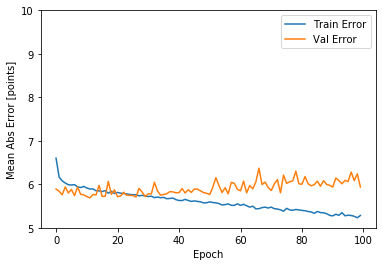

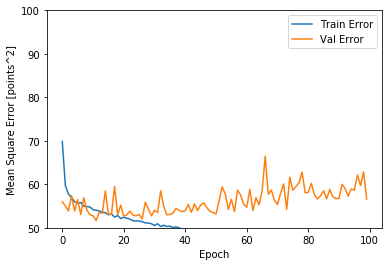

In [195]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [points]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([5,10])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [points^2]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([50,100])
  plt.legend()
  plt.show()
plot_history(history)


..

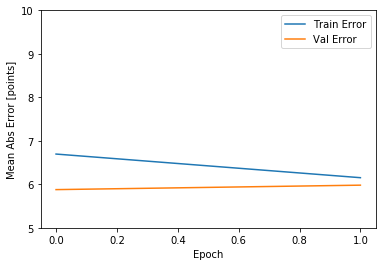

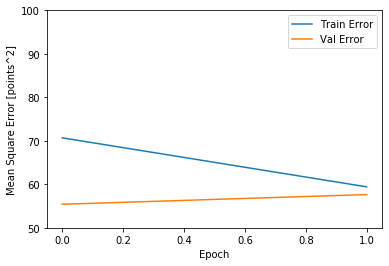

In [196]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss')

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [197]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} points".format(mae))

1176/1176 - 0s - loss: 61.3246 - mae: 6.0891 - mse: 61.3246
Testing set Mean Abs Error:  6.09 points


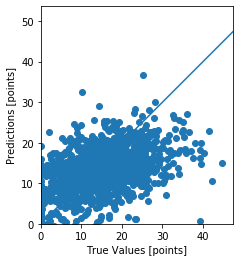

In [198]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [points]')
plt.ylabel('Predictions [points]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

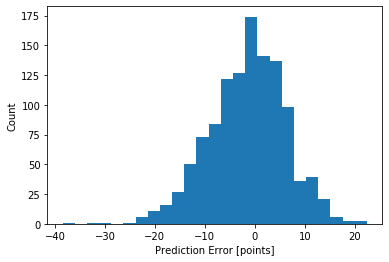

In [199]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [points]")
_ = plt.ylabel("Count")